In [1]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split




# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe ptnt_demog 


In [29]:
ptnt_demog = pd.DataFrame.from_csv('ADMISSIONS_ICUSTAY_SEPSIS.csv')
ptnt_demog.head()

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime
subject_id,,,,,,,,,,,,,,,,
21,M,2047-04-04 00:00:00,2135-02-08 00:00:00,1,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,2135-01-30 20:53:34,2135-02-08 05:38:46
94,M,2101-09-20 00:00:00,2178-08-17 00:00:00,1,2176-02-25 16:49:00,2176-02-29 17:45:00,NaN,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,2176-02-25 16:50:03,2176-02-26 19:11:57
157,M,2025-12-03 00:00:00,2106-08-25 00:00:00,1,2106-06-17 19:51:00,2106-06-24 17:50:00,NaN,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,2106-06-17 19:51:46,2106-06-21 22:43:29
166,F,1805-01-23 00:00:00,2105-01-24 00:00:00,1,2105-01-23 22:57:00,2105-01-24 03:48:00,2105-01-24 03:48:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,2105-01-23 23:00:10,2105-01-24 05:39:49
188,M,2105-05-18 00:00:00,2162-01-17 00:00:00,1,2157-03-07 11:08:00,2157-03-10 13:50:00,NaN,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,2157-03-07 11:08:51,2157-03-08 15:42:30


Date and time data imported in string format is converted to pandas.datetime objects

In [30]:
#transforms date time data imported in string format to pandas.datetime objects. 
dates_and_times = ['dob', 'dod', 'admittime', 'dischtime', 'deathtime', 'intime', 'outtime']
for thing in dates_and_times:
    ptnt_demog[thing] = pd.to_datetime(ptnt_demog[thing])
    
ptnt_demog.head()


,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime
subject_id,,,,,,,,,,,,,,,,
21,M,2047-04-04,2135-02-08,1,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,2135-01-30 20:53:34,2135-02-08 05:38:46
94,M,2101-09-20,2178-08-17,1,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,2176-02-25 16:50:03,2176-02-26 19:11:57
157,M,2025-12-03,2106-08-25,1,2106-06-17 19:51:00,2106-06-24 17:50:00,NaT,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,2106-06-17 19:51:46,2106-06-21 22:43:29
166,F,1805-01-23 00:00:00,2105-01-24,1,2105-01-23 22:57:00,2105-01-24 03:48:00,2105-01-24 03:48:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,2105-01-23 23:00:10,2105-01-24 05:39:49
188,M,2105-05-18,2162-01-17,1,2157-03-07 11:08:00,2157-03-10 13:50:00,NaT,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,2157-03-07 11:08:51,2157-03-08 15:42:30


In [31]:
#for patient age, only the date information is needed so datetime data is converted to date
ptnt_demog['dob'] = ptnt_demog['dob'].apply(lambda x: x.date())
ptnt_demog['dod'] = ptnt_demog['dod'].apply(lambda x: x.date())
ptnt_demog[['dob', 'dod']].head()

,dob,dod
subject_id,,
21,2047-04-04,2135-02-08
94,2101-09-20,2178-08-17
157,2025-12-03,2106-08-25
166,1805-01-23,2105-01-24
188,2105-05-18,2162-01-17


In [32]:
#dates_and_times = ['dob', 'dod', 'admittime', 'dischtime', 'deathtime', 'intime', 'outtime']
#checking for null values in the data
for item in dates_and_times:
    isanan = ptnt_demog[item].isnull().values.any()
    print "{}   {}".format(item, isanan)

dob   False
dod   True
admittime   False
dischtime   False
deathtime   True
intime   False
outtime   False


In [33]:
#dod and deathtime are NaT for patients who did not die in hospital or who had not been confirmed dead
#at the time of the data collection. 
ptnt_demog[ptnt_demog['dod'].isnull()].head()

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime
subject_id,,,,,,,,,,,,,,,,
366,M,2112-05-22,NaT,0,2164-11-18 20:27:00,2164-11-22 15:18:00,NaT,SEPSIS,0,Medicare,SINGLE,HISPANIC OR LATINO,MICU,MICU,2164-11-18 20:28:22,2164-11-21 00:36:11
406,F,2058-01-29,NaT,0,2119-08-25 22:37:00,2119-09-01 18:00:00,NaT,SEPSIS,0,Medicaid,MARRIED,WHITE,MICU,MICU,2119-08-25 22:38:07,2119-08-28 18:40:47
406,F,2058-01-29,NaT,0,2126-03-11 23:06:00,2126-03-26 16:17:00,NaT,SEPSIS,0,Medicare,MARRIED,WHITE,MICU,CCU,2126-03-11 23:07:15,2126-03-18 22:17:14
406,F,2058-01-29,NaT,0,2120-09-17 05:03:00,2120-09-28 12:15:00,NaT,SEPSIS,0,Medicaid,MARRIED,WHITE,MICU,MICU,2120-09-17 05:04:59,2120-09-20 18:42:54
558,M,2149-10-22,NaT,0,2200-03-11 00:33:00,2200-03-14 15:39:00,NaT,SEPSIS,0,Private,MARRIED,WHITE,MICU,MICU,2200-03-11 00:34:54,2200-03-12 12:20:43


# Calculating Patient Age, Hospital and ICU Stays
The age of patient at the time of admission was calculated. Also calculated was the duration of 
hospital stay and duration of ICU stay. 
    

In [34]:
'''the code calculates age of patient at time of admission, hospital stay and ICU stay. 
    using relativedelta.years to get the age rounded to years,
    relativedelta.days to get hospital stay in days and relativedelta.hours
    to get icu stay in hours.
    '''
# age at time of admission is calculated as admittime - dob
for index, row in ptnt_demog.iterrows():
    age_val = relativedelta(row['admittime'], row['dob']).years
    ptnt_demog.set_value(index, 'age', age_val)
        
    #adm_stay in days
    adm_stay_val = relativedelta(row['dischtime'],row['admittime'])
    adm_stay_val = adm_stay_val.weeks*7 + adm_stay_val.days
    #icu_stay in hours
    icu_stay_val = relativedelta(row['outtime'],row['intime'])
    icu_stay_val = icu_stay_val.weeks*7*24 + icu_stay_val.days*24 + icu_stay_val.hours
    ptnt_demog.set_value(index, 'adm_stay_days', adm_stay_val)
    ptnt_demog.set_value(index, 'icu_stay_hours', icu_stay_val)
    
ptnt_demog.head()

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,
21,M,2047-04-04,2135-02-08,1,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,2135-01-30 20:53:34,2135-02-08 05:38:46,87.0,15.0,368.0
94,M,2101-09-20,2178-08-17,1,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,2176-02-25 16:50:03,2176-02-26 19:11:57,74.0,4.0,26.0
157,M,2025-12-03,2106-08-25,1,2106-06-17 19:51:00,2106-06-24 17:50:00,NaT,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,2106-06-17 19:51:46,2106-06-21 22:43:29,80.0,6.0,98.0
166,F,1805-01-23,2105-01-24,1,2105-01-23 22:57:00,2105-01-24 03:48:00,2105-01-24 03:48:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,2105-01-23 23:00:10,2105-01-24 05:39:49,300.0,0.0,6.0
188,M,2105-05-18,2162-01-17,1,2157-03-07 11:08:00,2157-03-10 13:50:00,NaT,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,2157-03-07 11:08:51,2157-03-08 15:42:30,51.0,3.0,28.0


In [35]:
#relativedelta(ptnt_demog.iloc[0]['dod'], ptnt_demog.iloc[0]['dob']).years
ptnt_demog.columns

Index([u'gender', u'dob', u'dod', u'expire_flag', u'admittime', u'dischtime',
       u'deathtime', u'diagnosis', u'hospital_expire_flag', u'insurance',
       u'marital_status', u'ethnicity', u'first_careunit', u'last_careunit',
       u'intime', u'outtime', u'age', u'adm_stay_days', u'icu_stay_hours'],
      dtype='object')

In [36]:
#rename column
#ptnt_demog.rename(index=str, columns={"adm_stay_days": "hosp_stay_days"})

# Reality Check on Ages and Durations of Stay
Checking durations of stay and ages on low end for values < 0. Checking ages on the high end at 110yrs. 
Because I'm not sure what an unreasonable durations of stay would be for ICU or hospital stay will look for 
outliers in the data using statistical analysis later in preprocessing. 


In [37]:
ptnt_demog[ptnt_demog['age'] <  0]

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,


## There are approximately 93 patients whos calculated age is > 110. All are > 300yrs. 

In [38]:
age_replace_vals = list(ptnt_demog[ptnt_demog['age'] > 110]['age'].unique())


In [39]:
age_replace_vals

[300.0, 307.0, 302.0, 305.0, 306.0, 303.0, 301.0, 310.0]

In [40]:
ptnt_demog['age'].replace(age_replace_vals, np.nan, inplace = True)
ptnt_demog['age'].head()

subject_id
21     87.0
94     74.0
157    80.0
166     NaN
188    51.0
Name: age, dtype: float64

In [41]:
#checking again for age values > 110
ptnt_demog[ptnt_demog['age'] > 110]

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,


In [42]:
ptnt_demog[ptnt_demog['adm_stay_days'] < 0]

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,


In [43]:
ptnt_demog[ptnt_demog['adm_stay_days'] > 365]

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,


In [44]:
#ptnt_demog[ptnt_demog[['icu_stay']]<datetime.timedelta(days =0)] = np.nan
ptnt_demog[ptnt_demog['icu_stay_hours'] < 0]

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,


## Check for ICU stay longer than hospital stay 
shows that 347 patients had ICU stays longer than their hospital stays. 
Previously believed admittime and dischtime encompassed all of hospital stay including ICU
Need to review data descriptions to better understand the relationship


In [45]:
ptnt_demog[ptnt_demog['icu_stay_hours'] > (ptnt_demog['adm_stay_days']*24)].shape

(347, 19)

In [46]:
type(ptnt_demog.iloc[0]['age'])


numpy.float64

In [47]:
ptnt_demog.head()

,gender,dob,dod,expire_flag,admittime,dischtime,deathtime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,intime,outtime,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,
21,M,2047-04-04,2135-02-08,1,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,2135-01-30 20:53:34,2135-02-08 05:38:46,87.0,15.0,368.0
94,M,2101-09-20,2178-08-17,1,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,2176-02-25 16:50:03,2176-02-26 19:11:57,74.0,4.0,26.0
157,M,2025-12-03,2106-08-25,1,2106-06-17 19:51:00,2106-06-24 17:50:00,NaT,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,2106-06-17 19:51:46,2106-06-21 22:43:29,80.0,6.0,98.0
166,F,1805-01-23,2105-01-24,1,2105-01-23 22:57:00,2105-01-24 03:48:00,2105-01-24 03:48:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,2105-01-23 23:00:10,2105-01-24 05:39:49,NaN,0.0,6.0
188,M,2105-05-18,2162-01-17,1,2157-03-07 11:08:00,2157-03-10 13:50:00,NaT,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,2157-03-07 11:08:51,2157-03-08 15:42:30,51.0,3.0,28.0


## Dropping columns that will not be used in analysis. 
These columns were used to calculate columns like age, admissions stay and ICU stay and are no longer useful. 
Except admittime which may be used to determine whether survival rates have changed over time. 

In [48]:
# and want to include the subject id as index so i'm creating ptnt_demog2 as a copy, then dropping columns from 
# ptnt_demog in place as i don't need the subject_id for the current analysis. 
ptnt_demog2 = ptnt_demog.drop(['dob', 'expire_flag', 'dod', 'dischtime', 'deathtime', 'intime', 'outtime'],axis = 1)
ptnt_demog.drop(['dob', 'expire_flag', 'dod', 'dischtime', 'deathtime', 'intime', 'outtime'],axis = 1, inplace = True)
ptnt_demog.head()

,gender,admittime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,
21,M,2135-01-30 20:50:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,87.0,15.0,368.0
94,M,2176-02-25 16:49:00,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,74.0,4.0,26.0
157,M,2106-06-17 19:51:00,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,80.0,6.0,98.0
166,F,2105-01-23 22:57:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,NaN,0.0,6.0
188,M,2157-03-07 11:08:00,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,51.0,3.0,28.0


In [50]:
ptnt_demog.set_index(np.arange(ptnt_demog.shape[0]), inplace = True)
ptnt_demog.head()

,gender,admittime,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,age,adm_stay_days,icu_stay_hours
0,M,2135-01-30 20:50:00,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,87.0,15.0,368.0
1,M,2176-02-25 16:49:00,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,74.0,4.0,26.0
2,M,2106-06-17 19:51:00,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,80.0,6.0,98.0
3,F,2105-01-23 22:57:00,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,NaN,0.0,6.0
4,M,2157-03-07 11:08:00,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,51.0,3.0,28.0


In [45]:
'''
Sample code that was used to manually calculate dates and times from strings
def to_timedelta(time_string): 
    age = time_string.split()
    days = age[0]
    hms = age[2].split(":")
    print hms
    delta = timedelta(days = int(days), hours = int(hms[0]), minutes = int(hms[1]), seconds = int(hms[2]))
    return delta
'''
'''this was code to manually convert the dates in the file to datetime objects
age = ptnt_demog.age.iloc[0]
print age
dummy = age.split()
print dummy
days = dummy[0]
print days
hms = dummy[2].split(":")
print hms

datetime_object = datetime.strptime(dob, '%Y %m %d %H:%M:%S')




and these are scraps of where i figured out i can just use to_datetime
ptnt_demog['dod2'] = pd.to_datetime(ptnt_demog['dod']) 
ptnt_demog.head()
onedate = to_timedelta(ptnt_demog.age.iloc[0])
otherdate =  to_timedelta(ptnt_demog.age.iloc[1])
print onedate - otherdate
print onedate

'''
'''example code for timedelta
from datetime import datetime, timedelta
# we specify the input and the format...
t = datetime.strptime("05:20:25","%H:%M:%S")
# ...and use datetime's hour, min and sec properties to build a timedelta
delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)


#durations like icu stay etc are imported as strings. the code below 
#converts durations in strings to timedelta for use as variable
from datetime import timedelta
from datetime import datetime

delta = timedelta(days = int(duration[0]), hours = int(duration[1]), minutes = int(duration[2]), seconds = int(duration[3]))
print delta
'''

In [21]:
ptnt_demog.columns

Index([u'gender', u'dob', u'dod', u'expire_flag', u'admittime', u'dischtime',
       u'deathtime', u'diagnosis', u'hospital_expire_flag', u'insurance',
       u'marital_status', u'ethnicity', u'first_careunit', u'last_careunit',
       u'intime', u'outtime', u'age', u'adm_stay_days', u'icu_stay_hours'],
      dtype='object')

In [51]:
ptnt_demog.drop('admittime', axis = 1, inplace = True)
ptnt_demog2.drop('admittime', axis = 1, inplace = True)

In [52]:
ptnt_demog2.to_csv('ADMISSIONS_ICUSTAY_SEPSIS_revised.csv')

In [24]:
cat_vars = list(ptnt_demog.columns[ptnt_demog.dtypes == object])
num_vars = list(ptnt_demog.columns[ptnt_demog.dtypes == 'float64'])

In [25]:
cat_vars

['gender',
 'dob',
 'dod',
 'diagnosis',
 'insurance',
 'marital_status',
 'ethnicity',
 'first_careunit',
 'last_careunit']

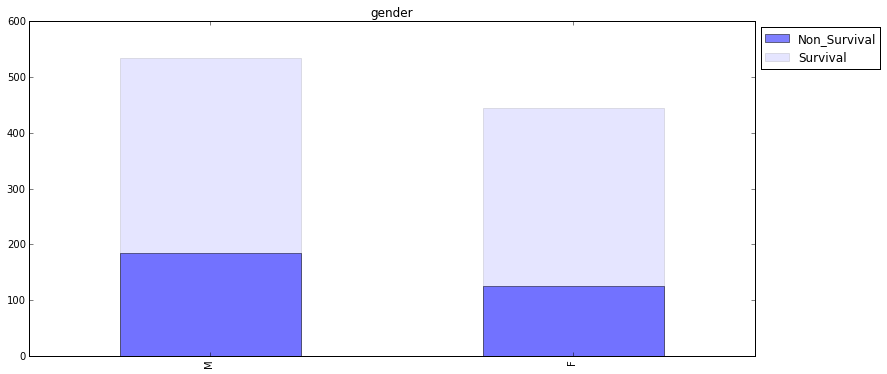

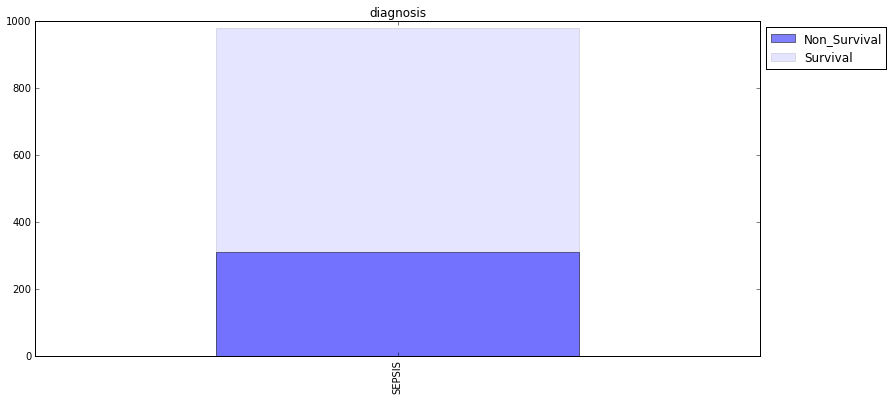

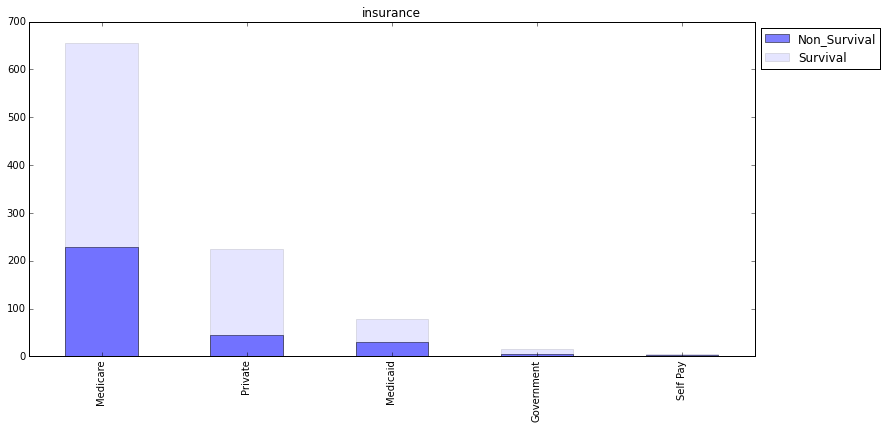

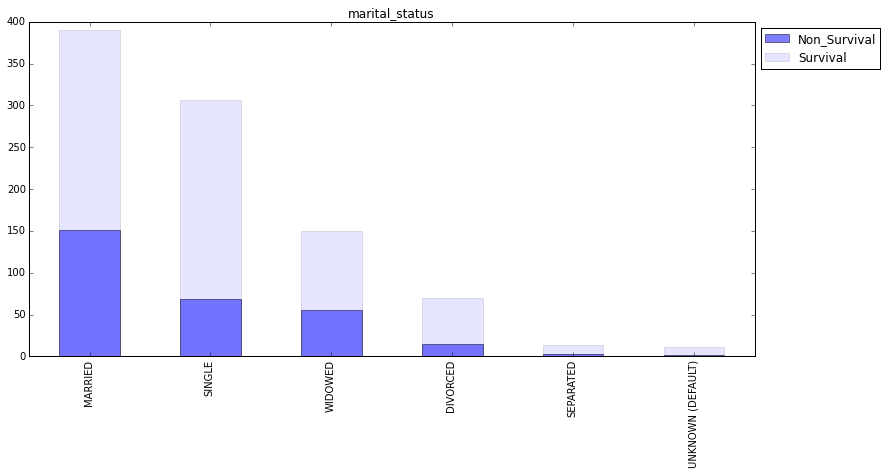

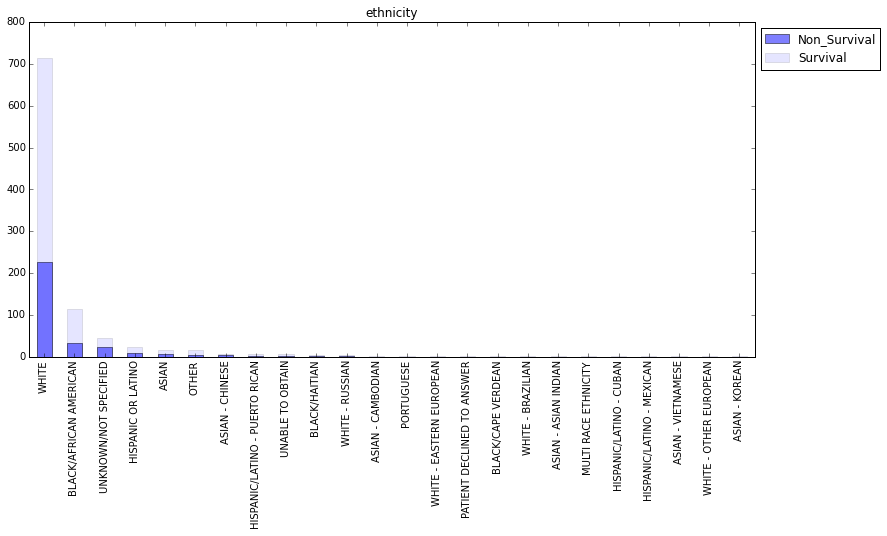

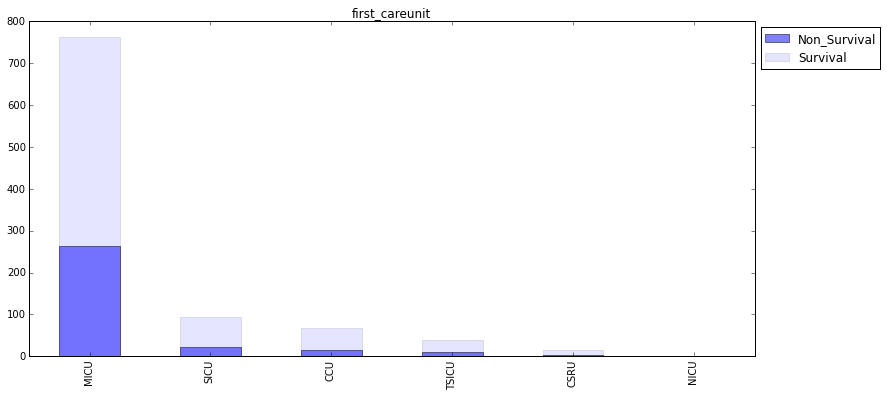

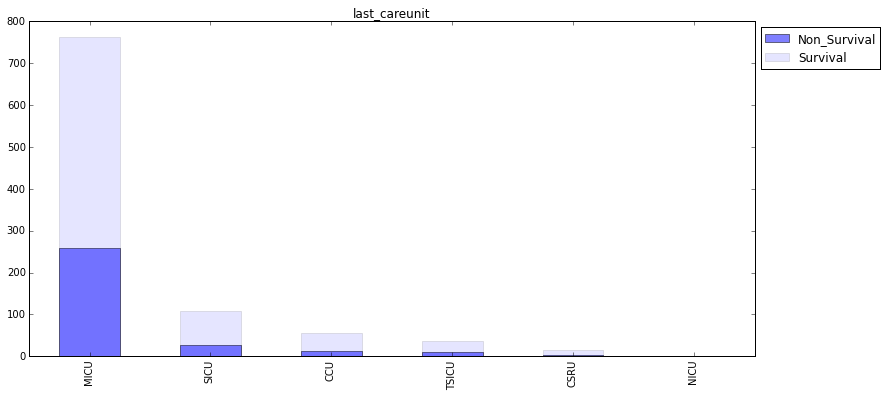

In [148]:
for item in cat_vars:
    
    # plot
    plt.subplots(figsize=(13,6))
    ptnt_demog[item][ptnt_demog.hospital_expire_flag==1].value_counts().plot.bar(
        alpha=0.5,label= 'Non_Survival')
    ptnt_demog[item][ptnt_demog.hospital_expire_flag==0].value_counts().plot.bar(
        alpha=0.1,label= 'Survival')
    
    # fake plots for KS test, median, etc
    '''
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    '''
    # add title, labels etc.
    plt.title(item)
    #plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    #if l in lab_ranges:
    #    plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
    #    plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

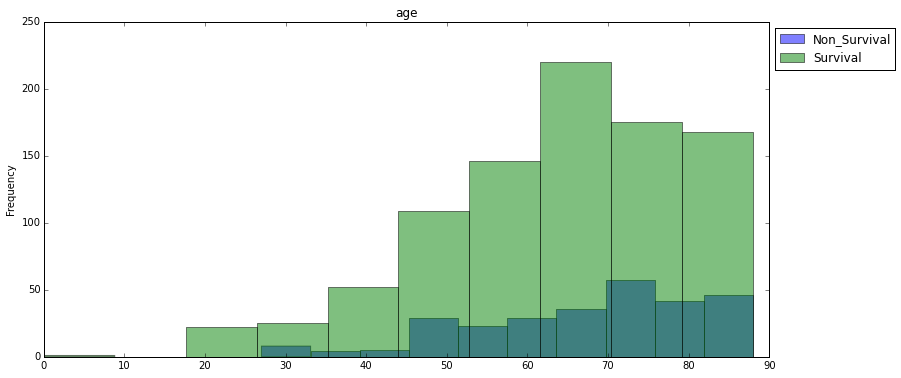

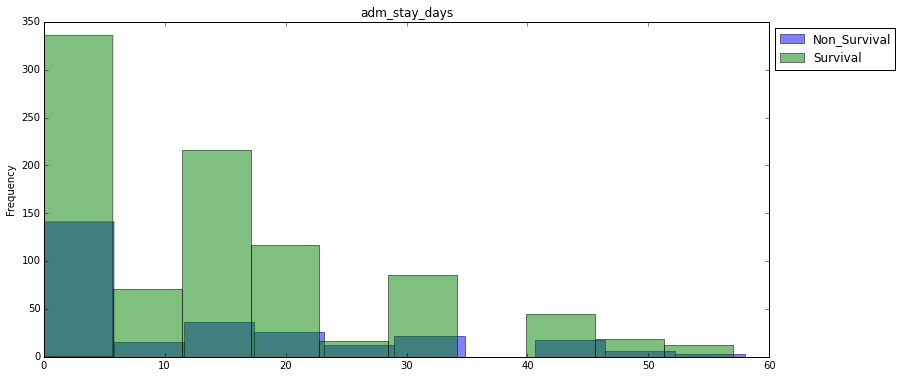

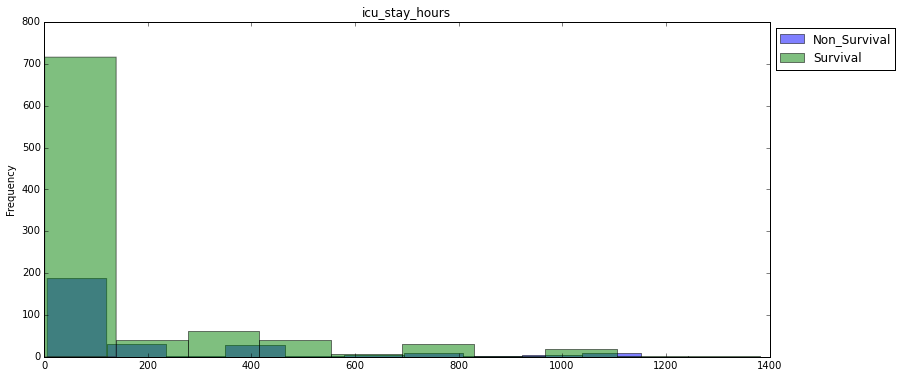

In [146]:
for item in num_vars:
    
    # plot
    plt.subplots(figsize=(13,6))
    ptnt_demog2[item][ptnt_demog.hospital_expire_flag==1].plot.hist(
        alpha=0.5,label= 'Non_Survival')
    ptnt_demog2[item][ptnt_demog.hospital_expire_flag==0].plot.hist(
        alpha=0.5,label= 'Survival')
    
    # fake plots for KS test, median, etc
    '''
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    '''
    # add title, labels etc.
    plt.title(item)
    #plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    #if l in lab_ranges:
    #    plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
    #    plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

#code for converting sql dates to date-time objects
from datetime import datetime
dob = ptnt_demog.iloc[0].dob.split()
ymd = dob[0].split('-')
print ymd
ymd.append(dob[1])
print ymd
dob = " ".join(ymd)

datetime_object = datetime.strptime(dob, '%Y %m %d %H:%M:%S')

In [24]:
from sklearn import preprocessing as prp


In [25]:
ptnt_demog.dtypes

gender                          object
admittime               datetime64[ns]
diagnosis                       object
hospital_expire_flag             int64
insurance                       object
marital_status                  object
ethnicity                       object
first_careunit                  object
last_careunit                   object
age                            float64
adm_stay_days                  float64
icu_stay_hours                 float64
dtype: object

In [50]:
ptnt_demog2 = ptnt_demog.copy()

In [51]:
cat_vars = list(ptnt_demog2.columns[ptnt_demog2.dtypes == object])
cat_vars

['gender',
 'diagnosis',
 'insurance',
 'marital_status',
 'ethnicity',
 'first_careunit',
 'last_careunit']

In [52]:
monkey = pd.get_dummies(ptnt_demog2[cat_vars])

In [53]:
ptnt_demog2.drop(cat_vars, axis = 1, inplace = True)
ptnt_demog2.head()


,admittime,hospital_expire_flag,age,adm_stay_days,icu_stay_hours
0,2135-01-30 20:50:00,1,87.0,15.0,368.0
1,2176-02-25 16:49:00,0,74.0,4.0,26.0
2,2106-06-17 19:51:00,0,80.0,6.0,98.0
3,2105-01-23 22:57:00,1,NaN,0.0,6.0
4,2157-03-07 11:08:00,0,51.0,3.0,28.0


In [58]:
ptnt_demog2 = ptnt_demog2.join(monkey)


In [65]:
cols = list(ptnt_demog2.columns)
cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
cols

['hospital_expire_flag',
 'admittime',
 'age',
 'adm_stay_days',
 'icu_stay_hours',
 'gender_F',
 'gender_M',
 'diagnosis_SEPSIS',
 'insurance_Government',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'insurance_Self Pay',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SEPARATED',
 'marital_status_SINGLE',
 'marital_status_UNKNOWN (DEFAULT)',
 'marital_status_WIDOWED',
 'ethnicity_ASIAN',
 'ethnicity_ASIAN - ASIAN INDIAN',
 'ethnicity_ASIAN - CAMBODIAN',
 'ethnicity_ASIAN - CHINESE',
 'ethnicity_ASIAN - KOREAN',
 'ethnicity_ASIAN - VIETNAMESE',
 'ethnicity_BLACK/AFRICAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_BLACK/CAPE VERDEAN',
 'ethnicity_BLACK/HAITIAN',
 'ethnicity_HISPANIC OR LATINO',
 'ethnicity_HISPANIC/LATINO - CUBAN',
 'ethnicity_HISPANIC/LATINO - MEXICAN',
 'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
 'ethnicity_MULTI RACE ETHNICITY',
 'ethnicity_OTHER',
 'ethnicity_PATIENT DECLINED TO ANSWER',
 'ethnicity_PORTUGUESE

In [68]:
ptnt_demog2 = ptnt_demog2[cols]
ptnt_demog2.head()

,hospital_expire_flag,admittime,age,adm_stay_days,icu_stay_hours,gender_F,gender_M,diagnosis_SEPSIS,insurance_Government,insurance_Medicaid,...,first_careunit_MICU,first_careunit_NICU,first_careunit_SICU,first_careunit_TSICU,last_careunit_CCU,last_careunit_CSRU,last_careunit_MICU,last_careunit_NICU,last_careunit_SICU,last_careunit_TSICU
0,1,2135-01-30 20:50:00,87.0,15.0,368.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,2176-02-25 16:49:00,74.0,4.0,26.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,2106-06-17 19:51:00,80.0,6.0,98.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,2105-01-23 22:57:00,NaN,0.0,6.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,2157-03-07 11:08:00,51.0,3.0,28.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


hospital_expire_flag
0    [[Axes(0.125,0.684722;0.215278x0.215278), Axes...
1    [[Axes(0.125,0.684722;0.215278x0.215278), Axes...
dtype: object

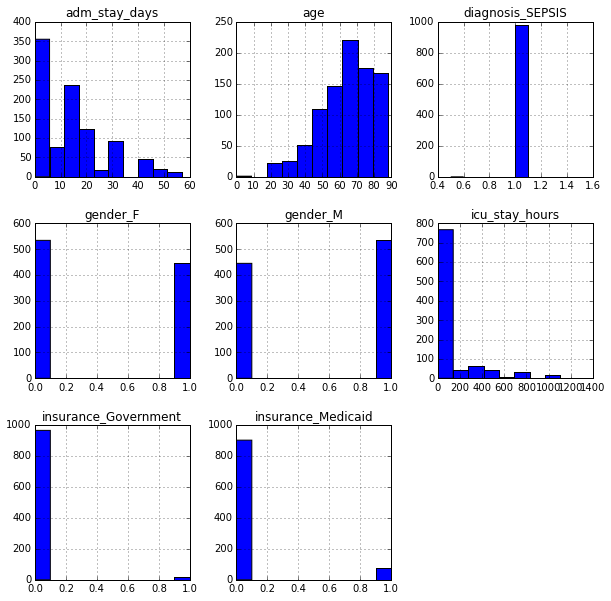

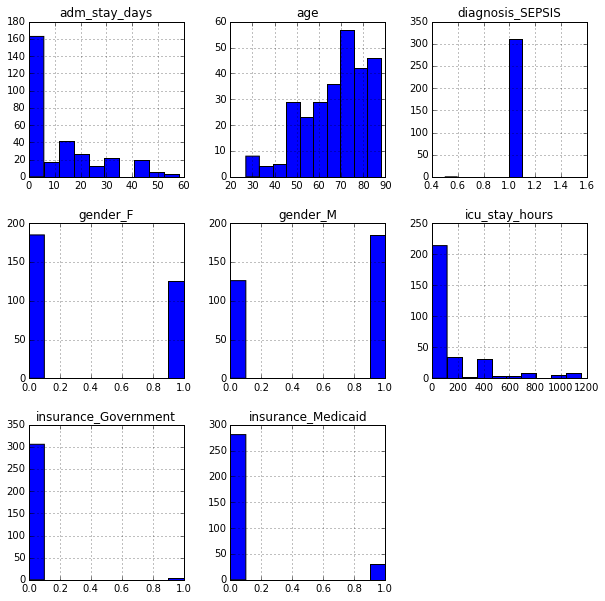

In [69]:
ptnt_demog2[ptnt_demog2.columns[:10]].groupby('hospital_expire_flag').hist(alpha = 0.5, figsize = (10, 10))

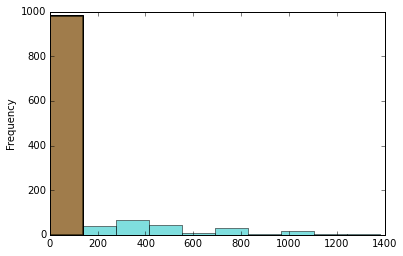

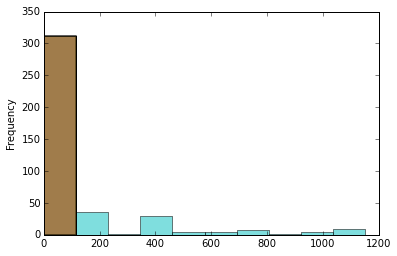

In [72]:
gr = ptnt_demog2.groupby('hospital_expire_flag')
for k, v in gr:
    v.plot(kind='hist', alpha=.5, legend = None)

## There appears to be very little observable difference between survivors and non-survivors in any of these variables. For this reason this analysis will be paused while a query is run to extract clinical data on septic patients. An initial exploration will then be performed on that data. 

In [94]:
ptnt_demog2.drop('admittime', axis=1, inplace = True)

In [95]:
cols=list(ptnt_demog2.columns[1:])
cols

['age',
 'adm_stay_days',
 'icu_stay_hours',
 'gender_F',
 'gender_M',
 'diagnosis_SEPSIS',
 'insurance_Government',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'insurance_Self Pay',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SEPARATED',
 'marital_status_SINGLE',
 'marital_status_UNKNOWN (DEFAULT)',
 'marital_status_WIDOWED',
 'ethnicity_ASIAN',
 'ethnicity_ASIAN - ASIAN INDIAN',
 'ethnicity_ASIAN - CAMBODIAN',
 'ethnicity_ASIAN - CHINESE',
 'ethnicity_ASIAN - KOREAN',
 'ethnicity_ASIAN - VIETNAMESE',
 'ethnicity_BLACK/AFRICAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_BLACK/CAPE VERDEAN',
 'ethnicity_BLACK/HAITIAN',
 'ethnicity_HISPANIC OR LATINO',
 'ethnicity_HISPANIC/LATINO - CUBAN',
 'ethnicity_HISPANIC/LATINO - MEXICAN',
 'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
 'ethnicity_MULTI RACE ETHNICITY',
 'ethnicity_OTHER',
 'ethnicity_PATIENT DECLINED TO ANSWER',
 'ethnicity_PORTUGUESE',
 'ethnicity_UNABLE TO OBTAIN',
 'eth

In [91]:
monkey = cols[2]
monkey

'adm_stay_days'

hospital_expire_flag
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: adm_stay_days, dtype: object

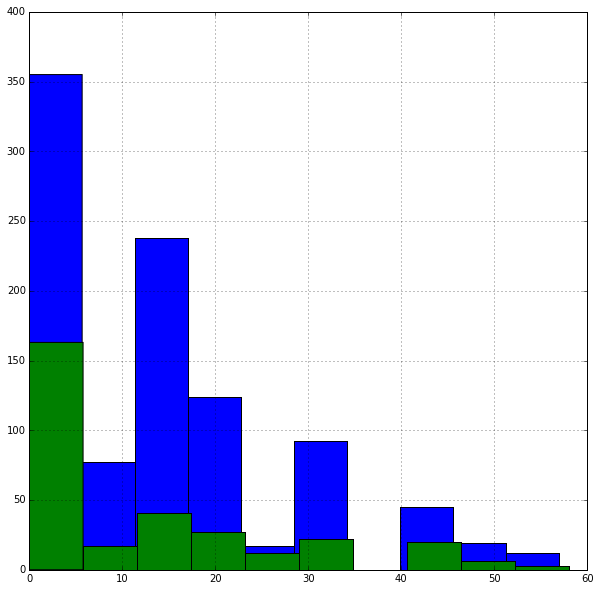

In [92]:
ptnt_demog2.groupby('hospital_expire_flag')[monkey].hist(alpha = 0.3, figsize = (10, 10))

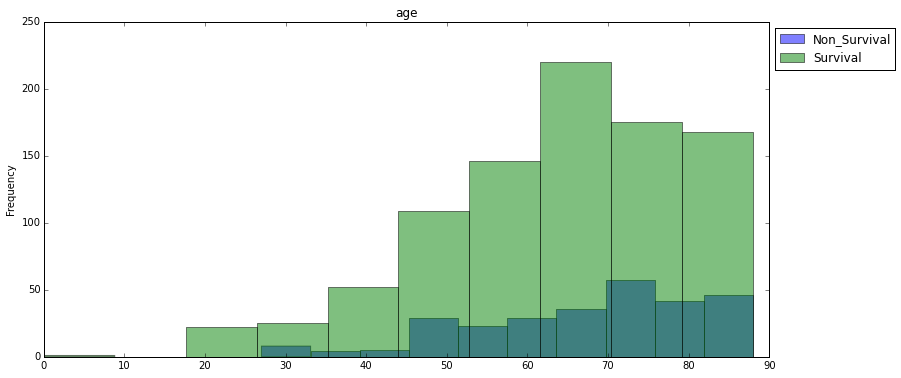

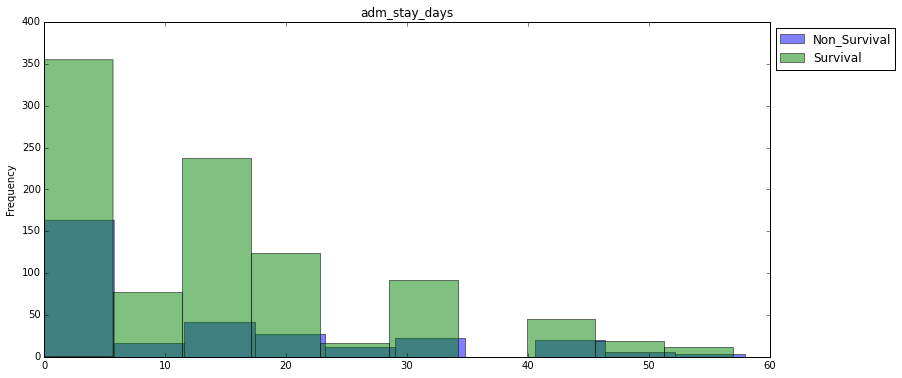

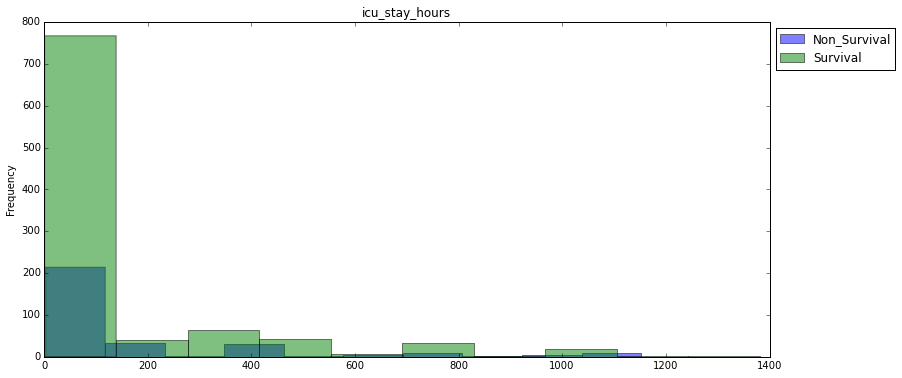

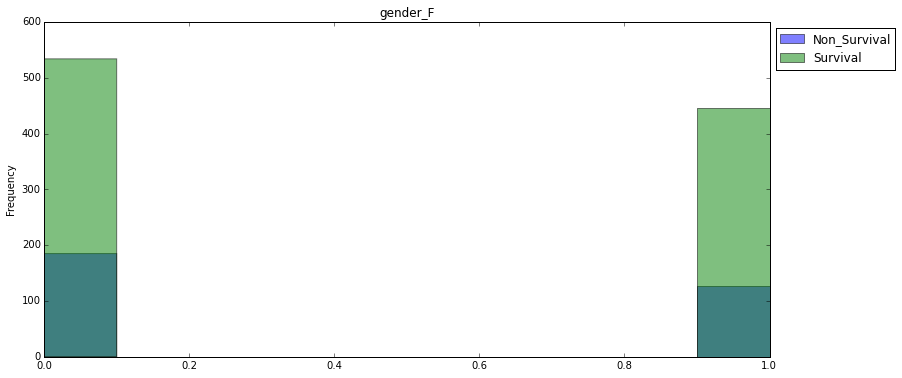

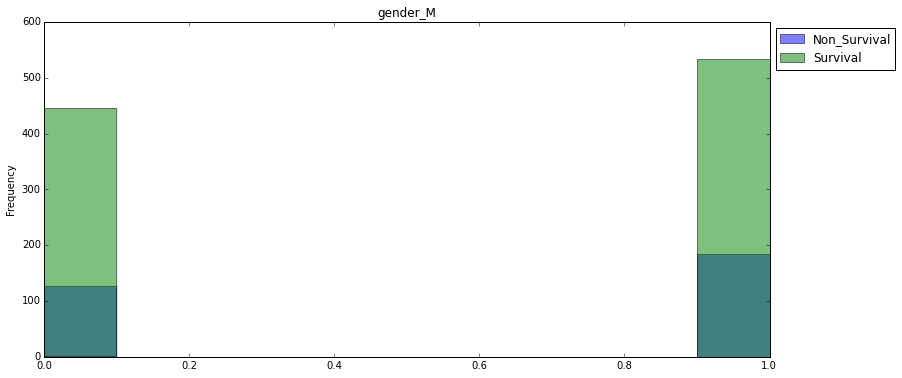

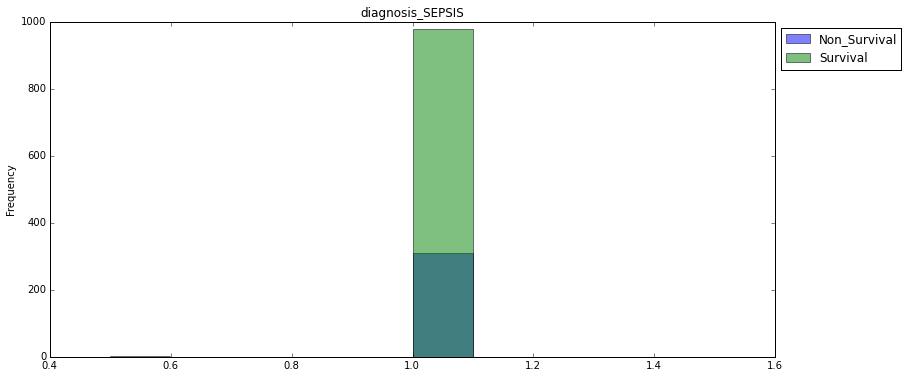

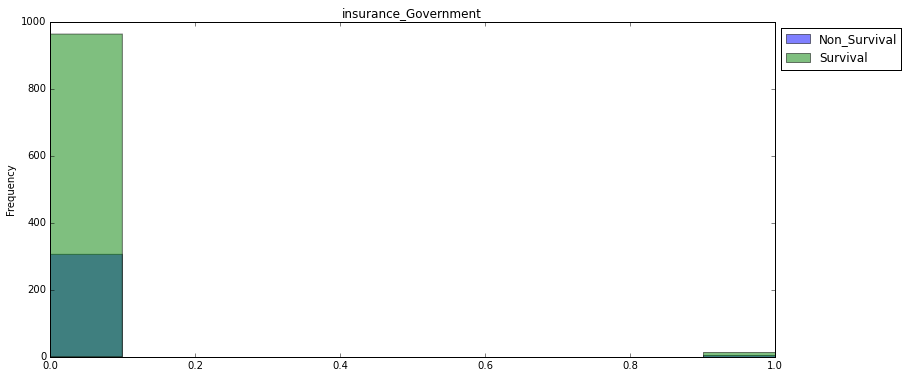

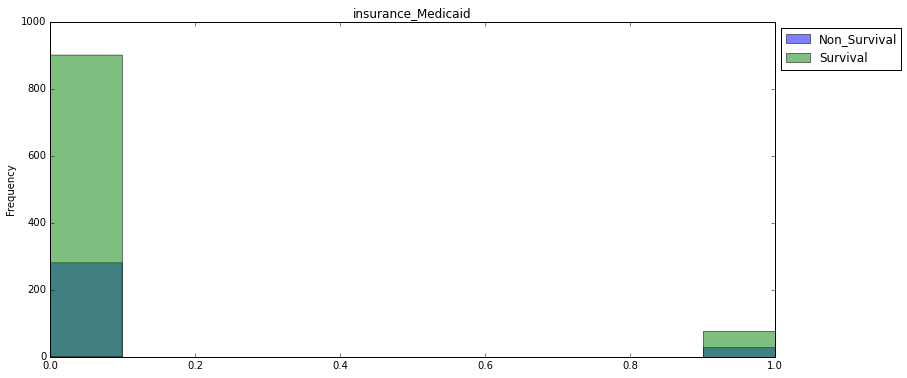

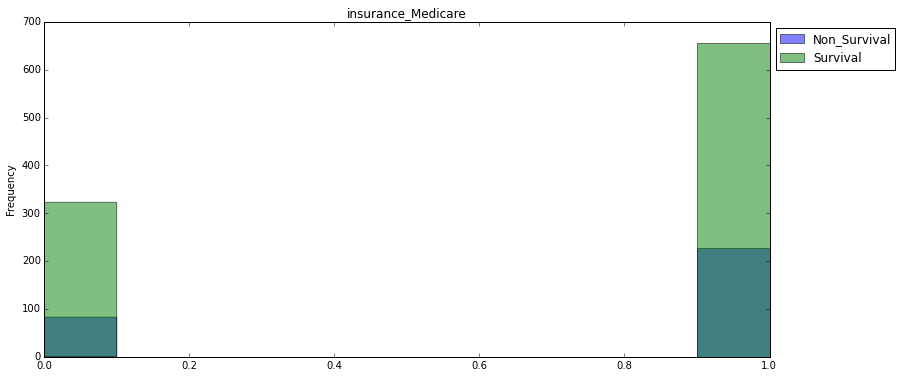

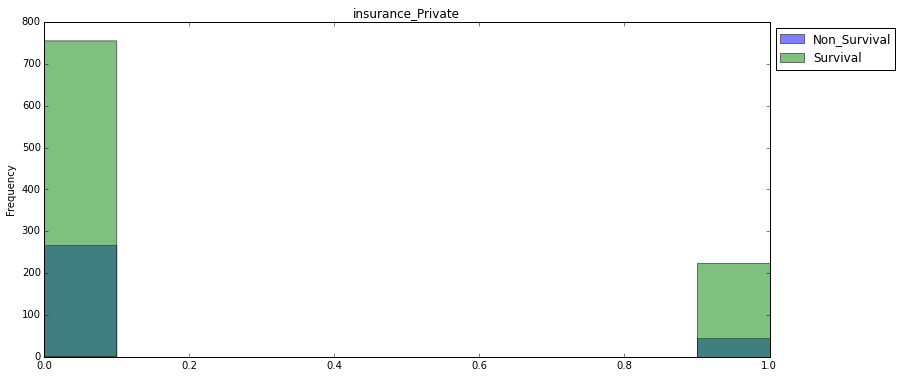

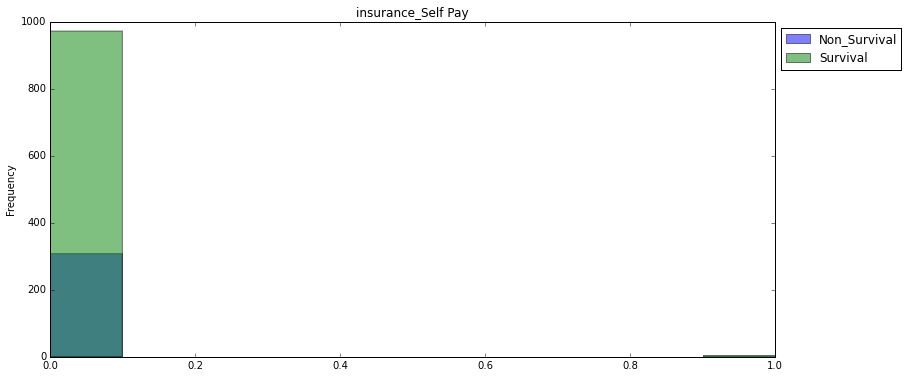

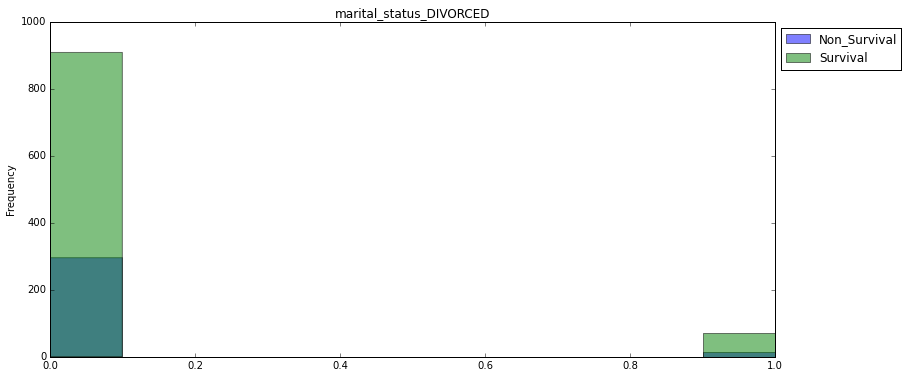

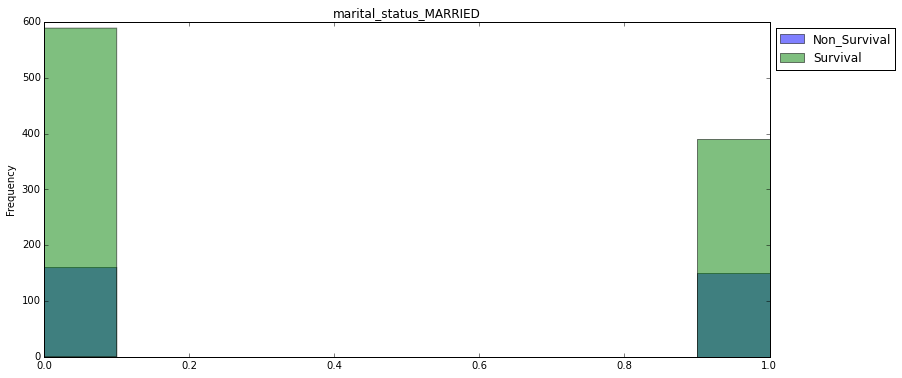

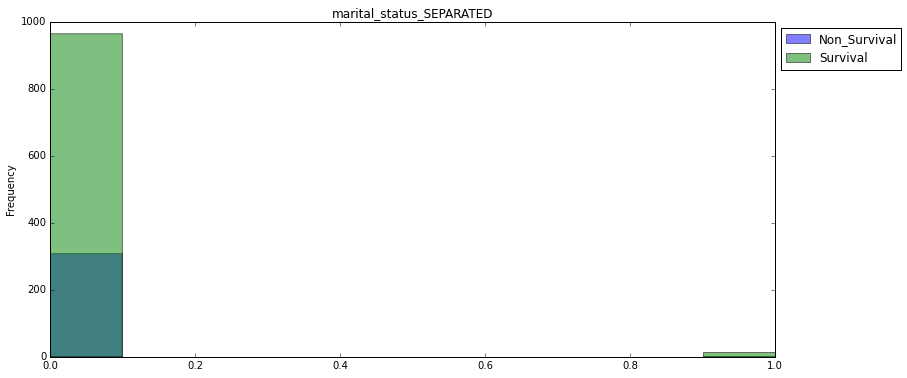

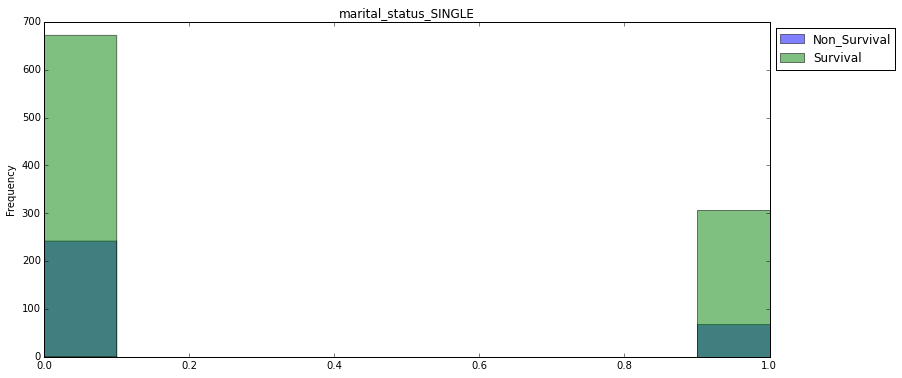

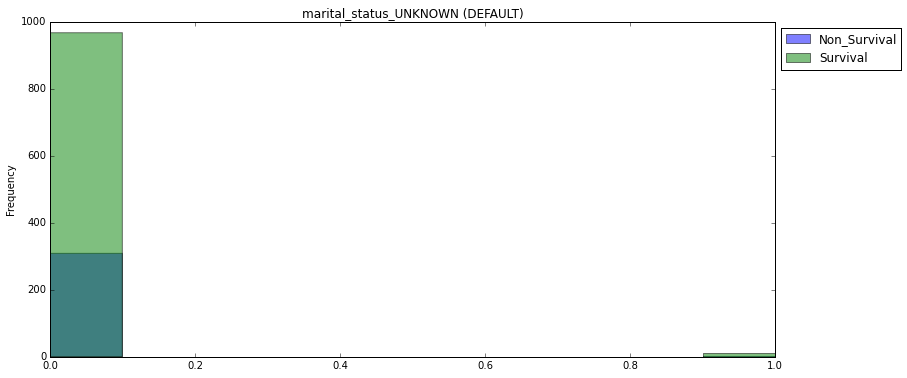

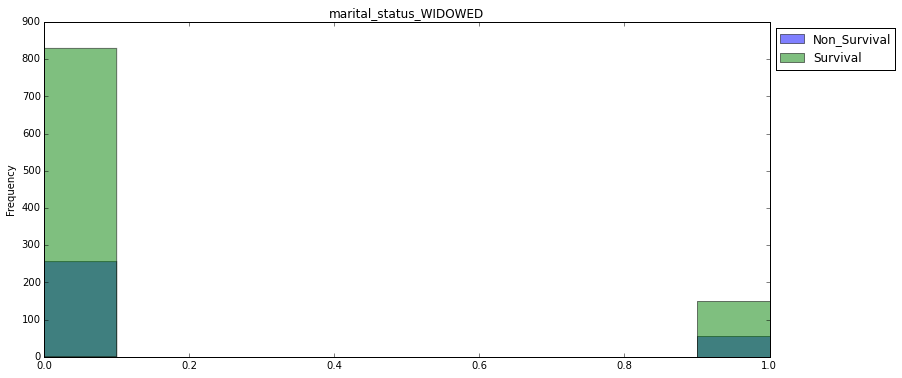

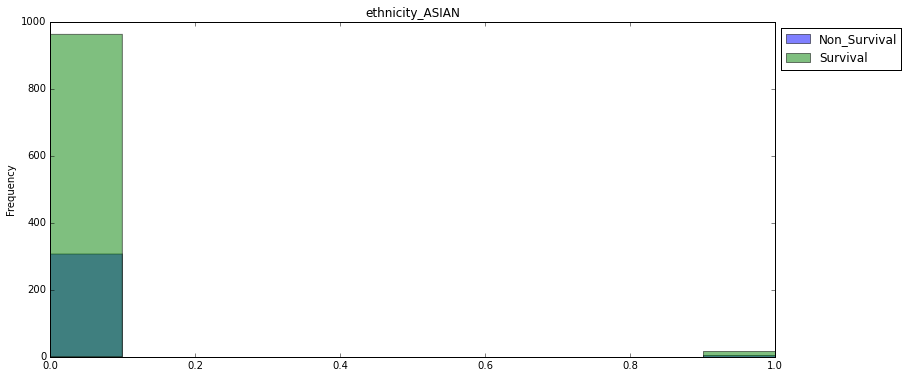

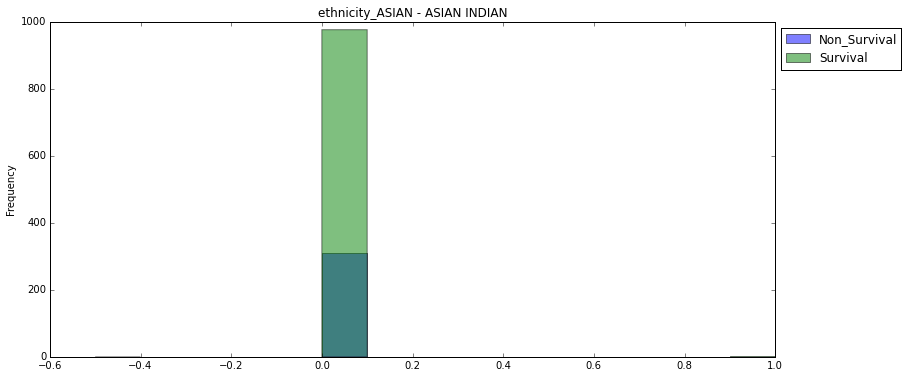

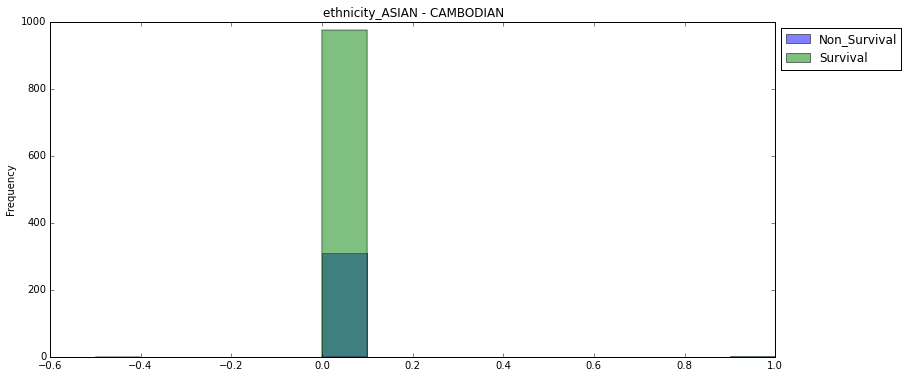

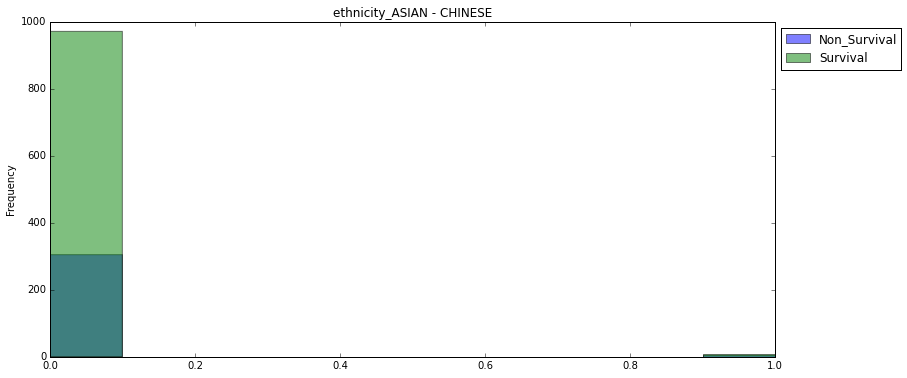

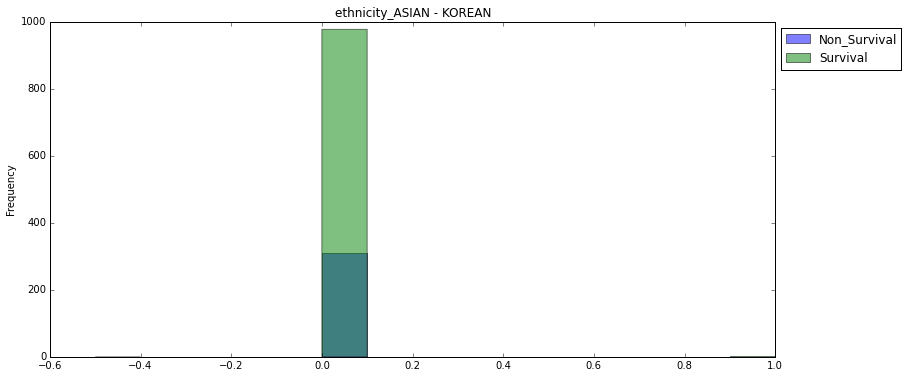

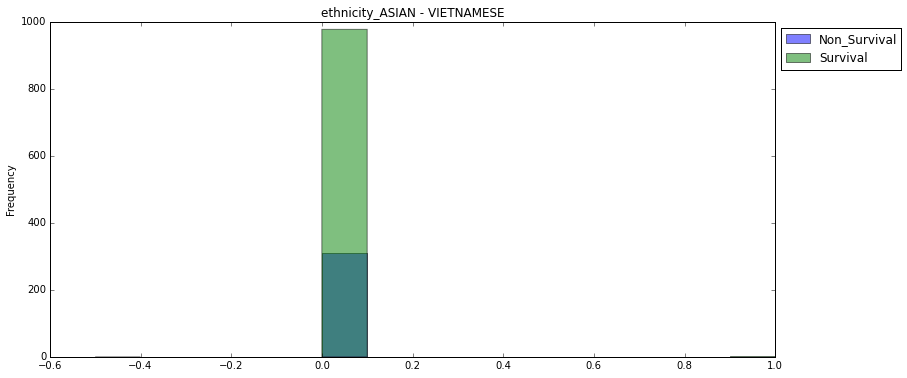

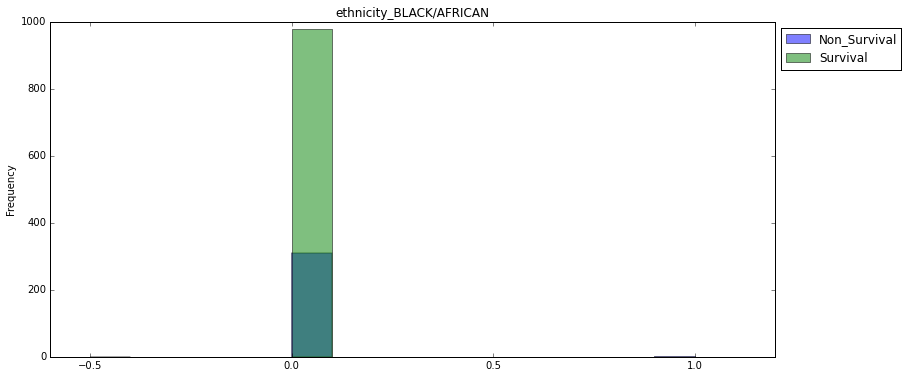

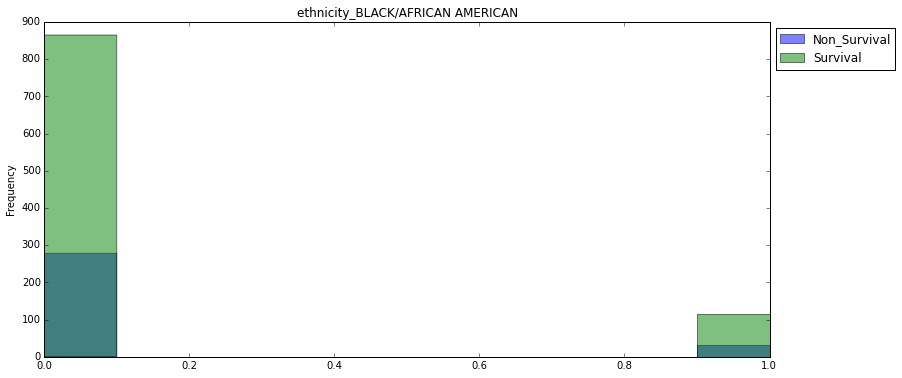

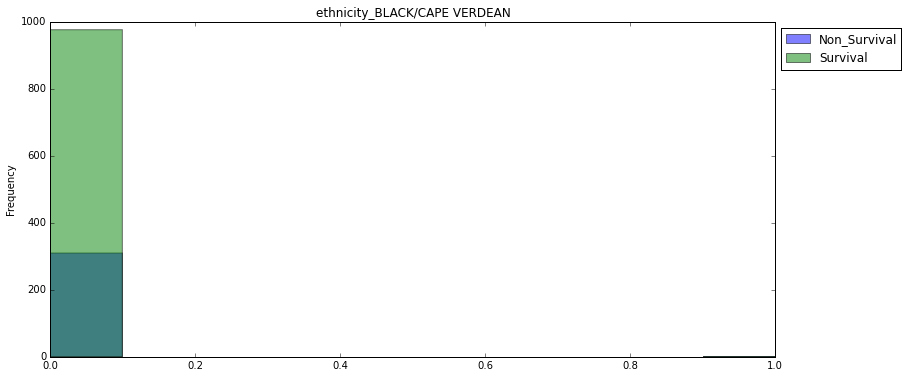

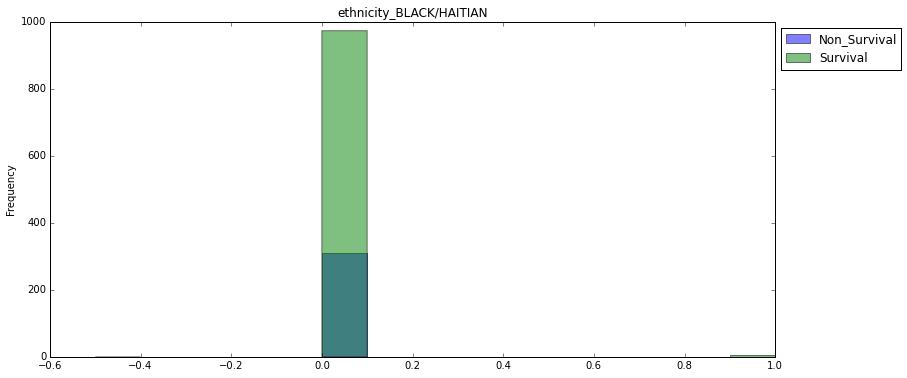

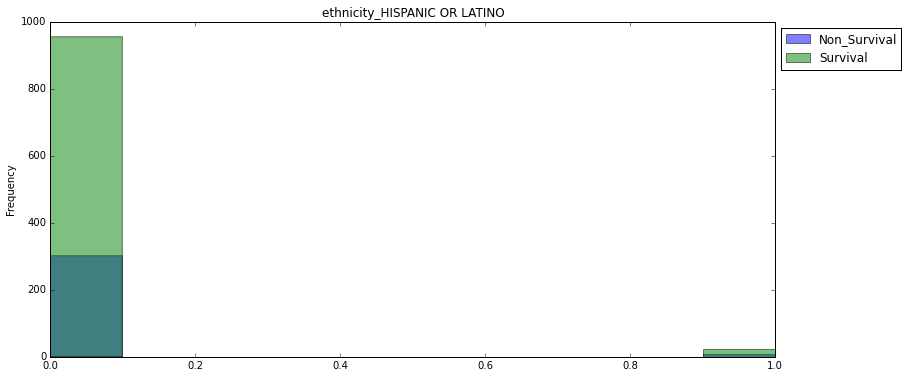

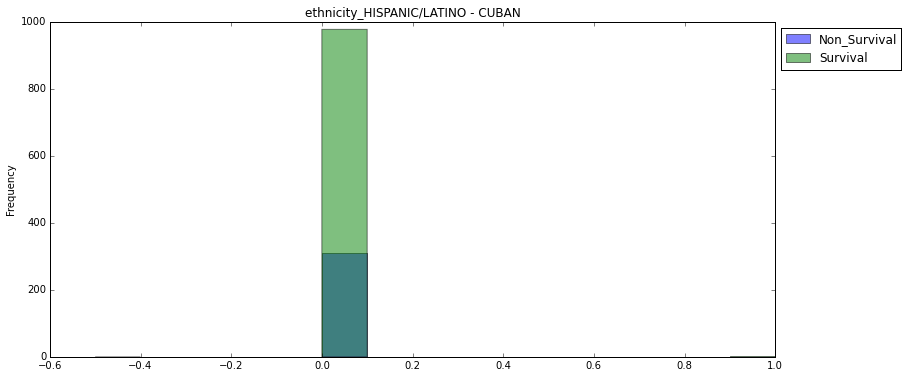

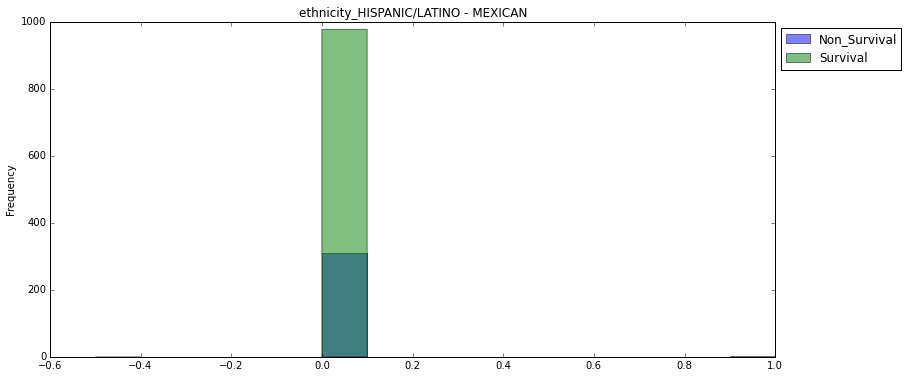

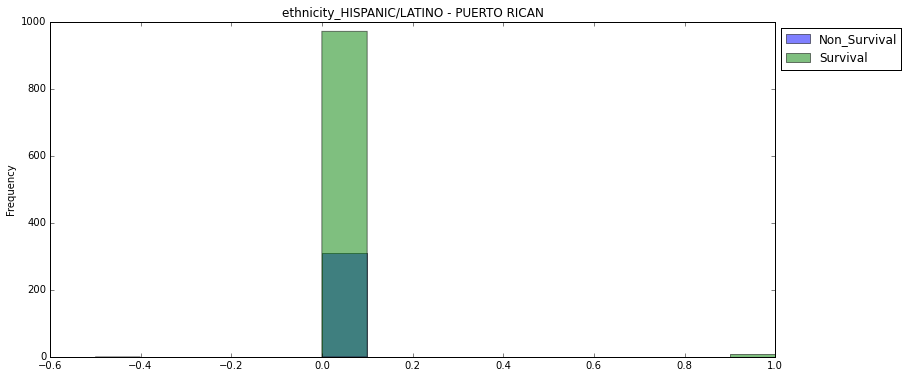

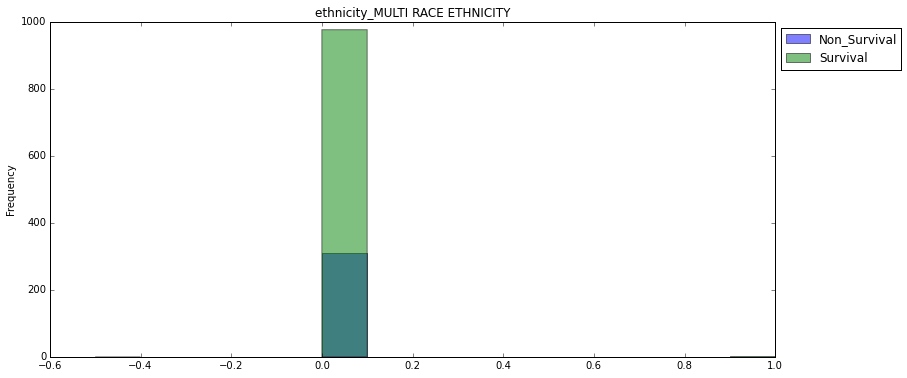

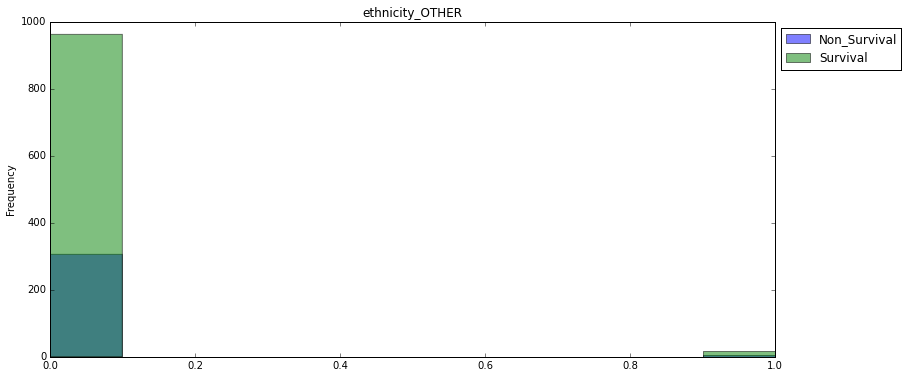

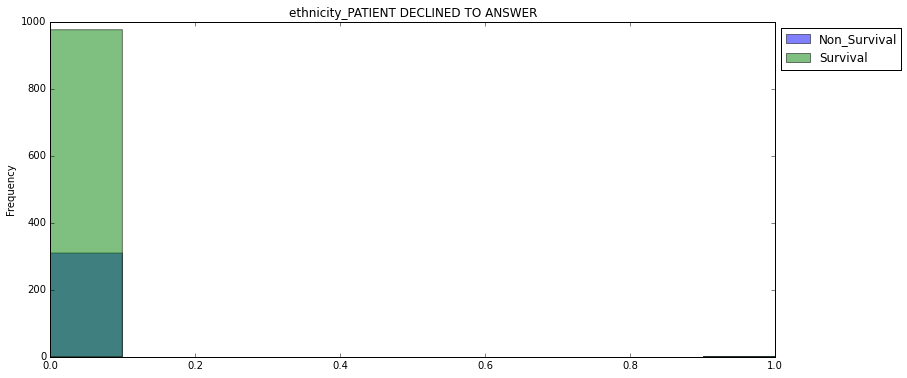

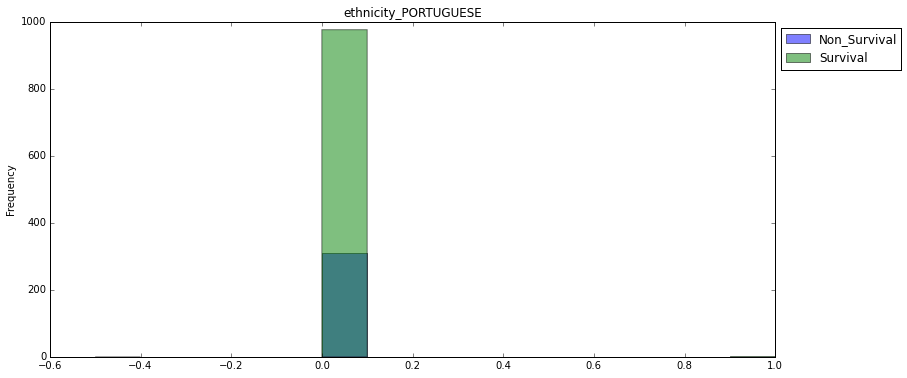

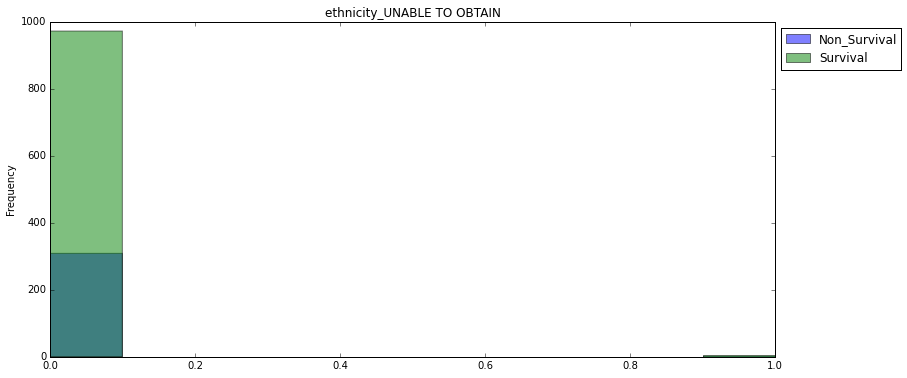

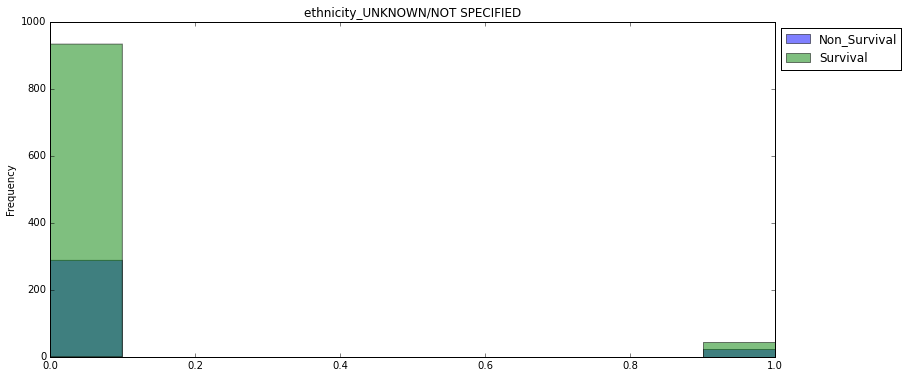

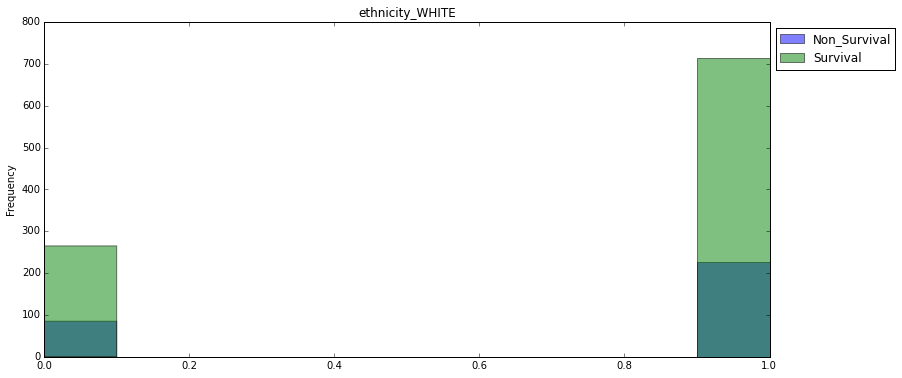

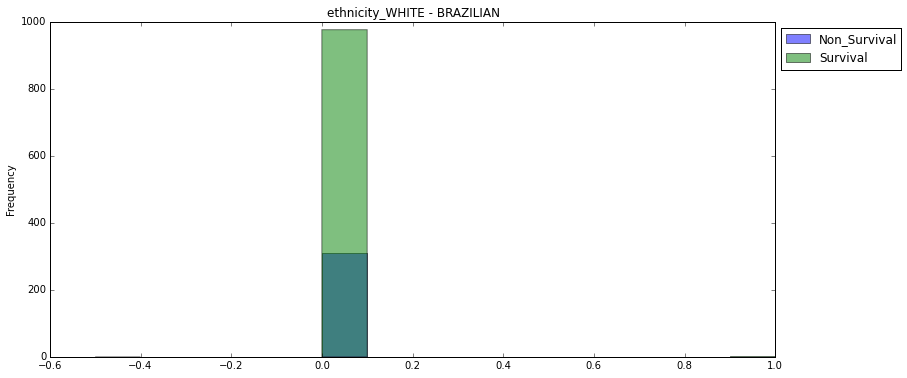

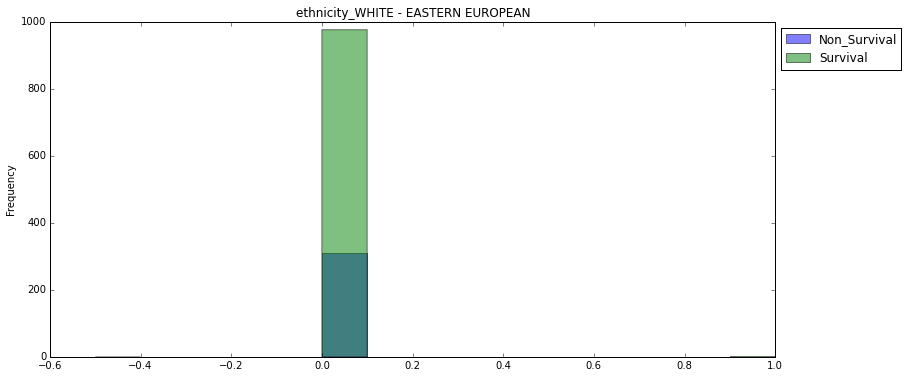

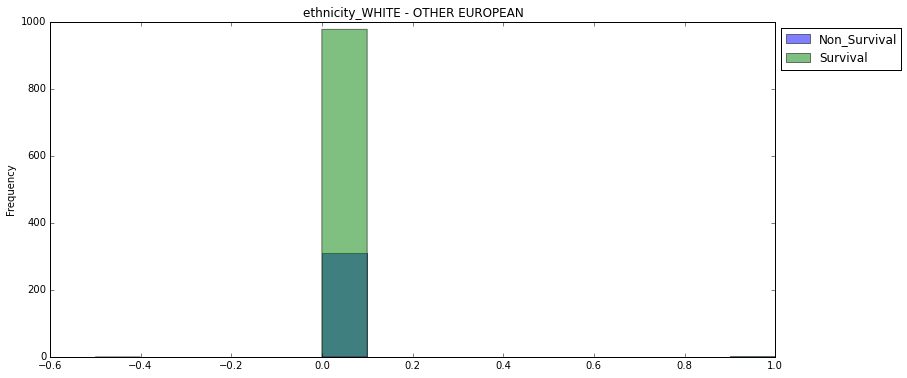

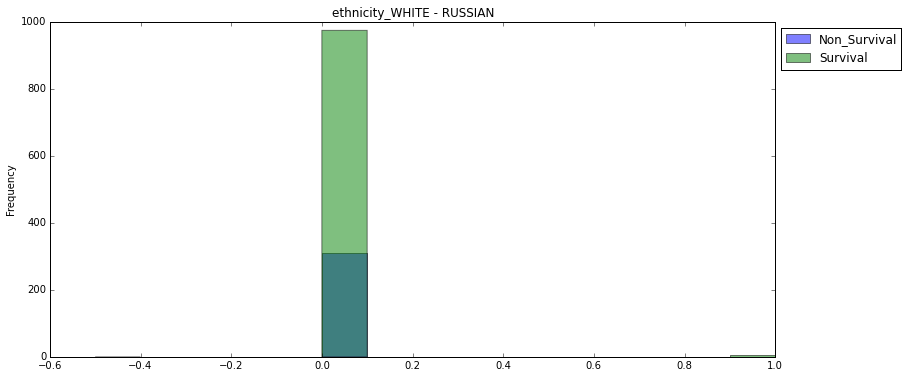

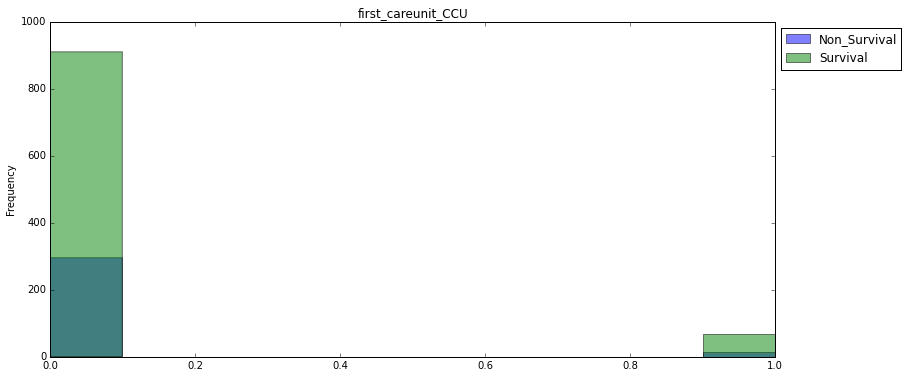

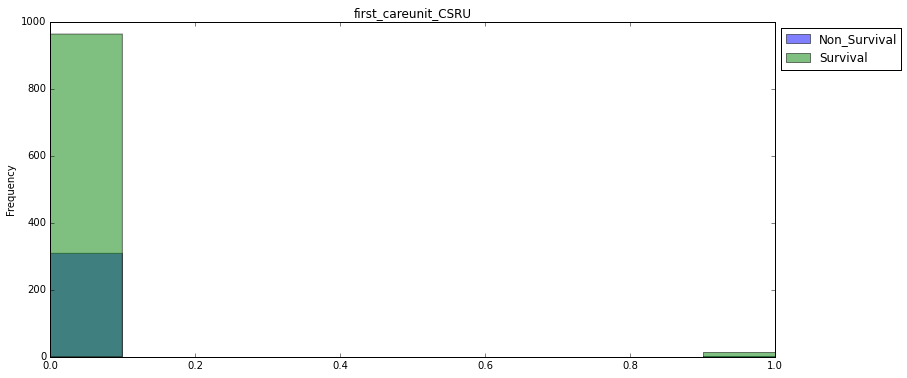

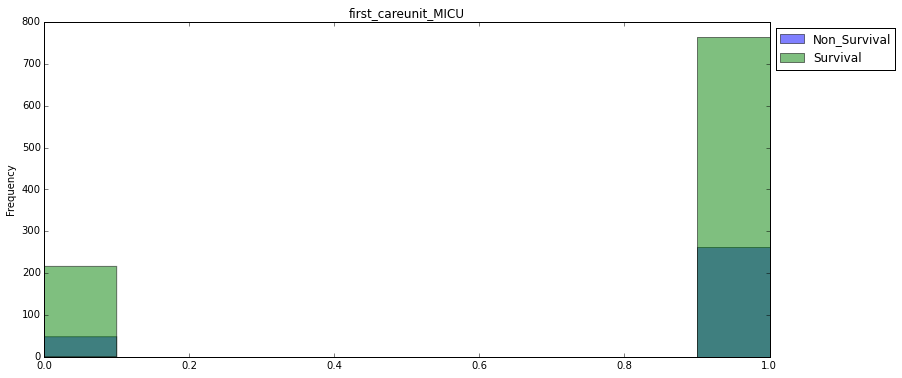

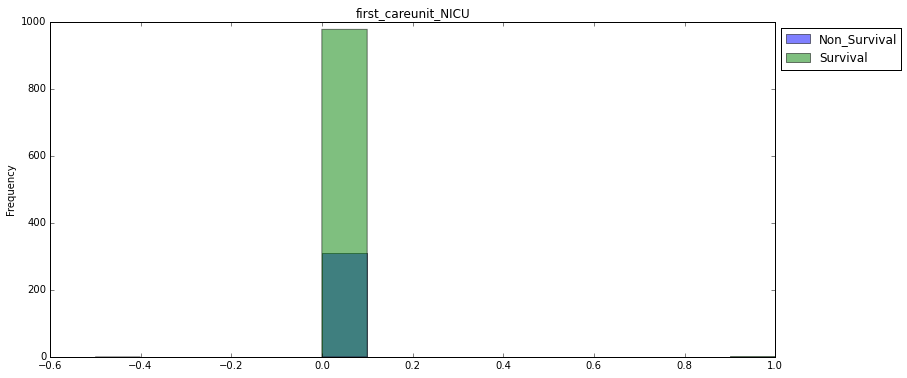

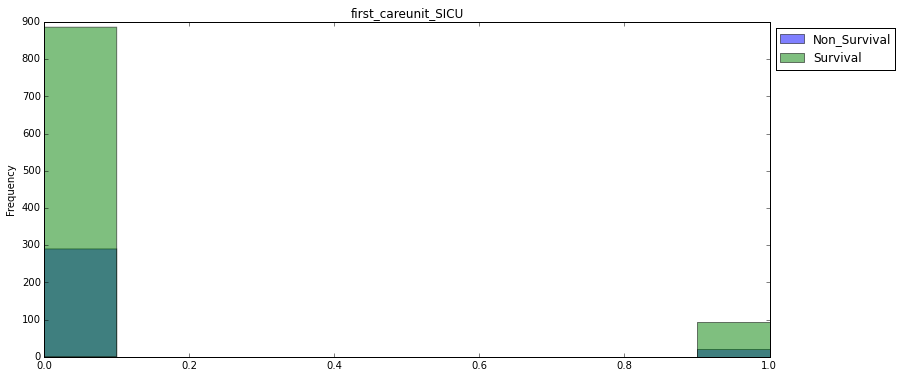

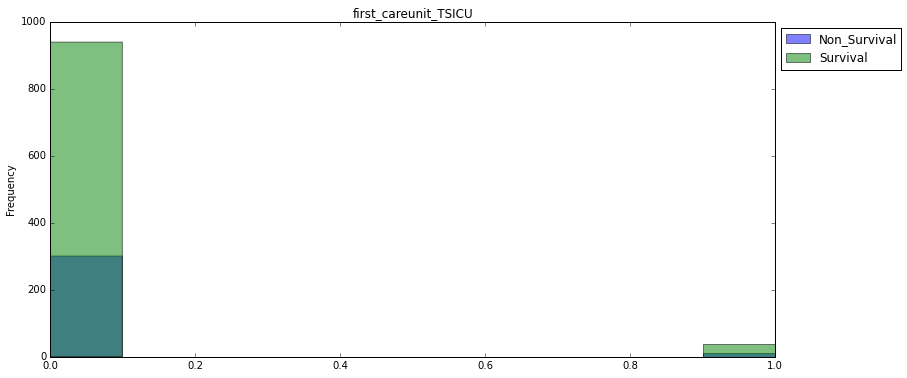

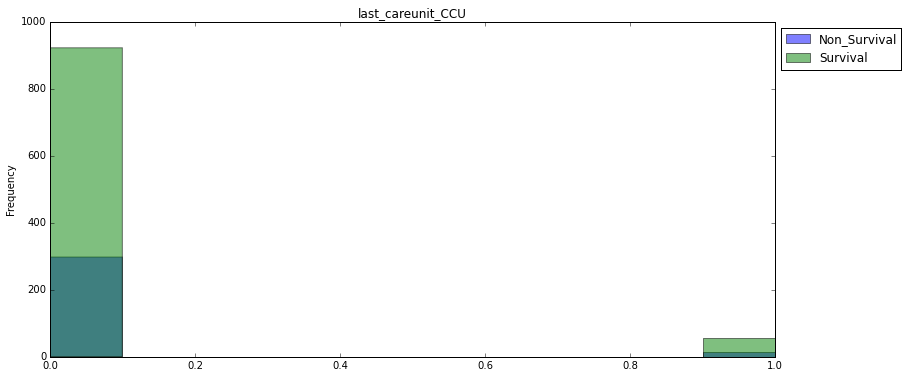

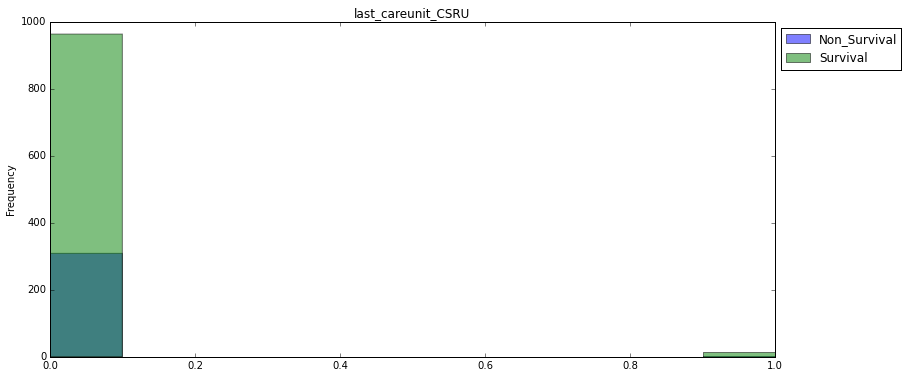

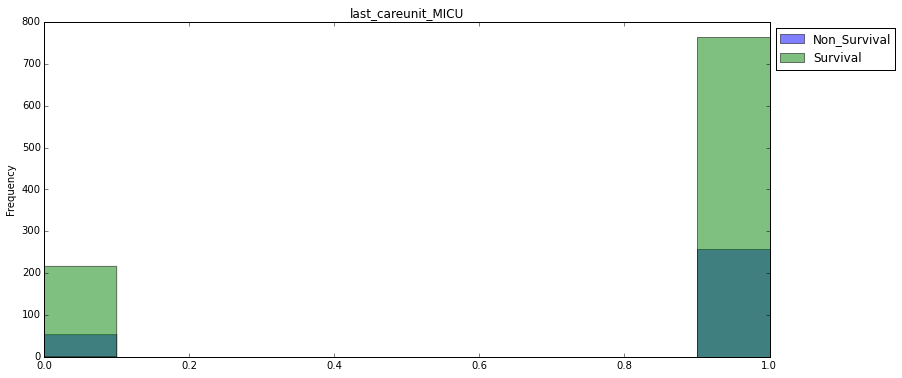

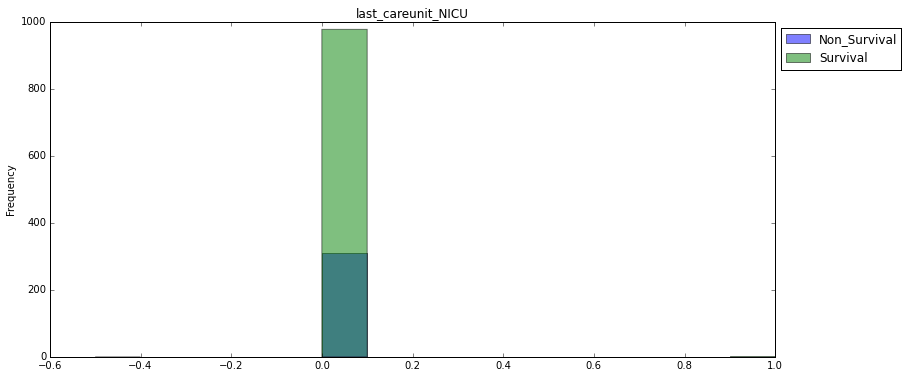

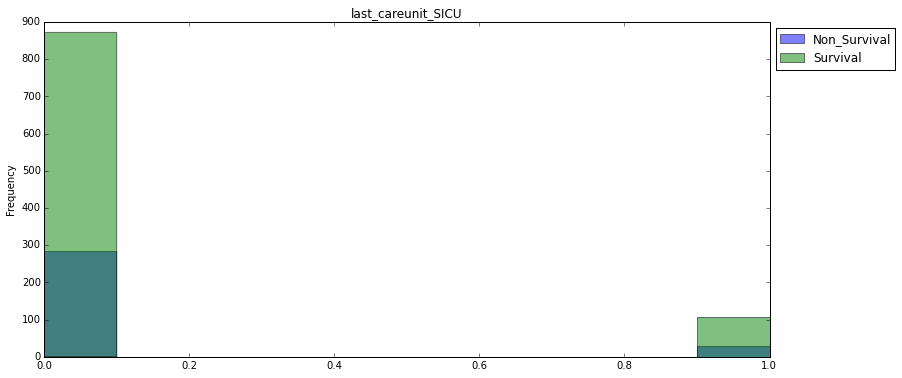

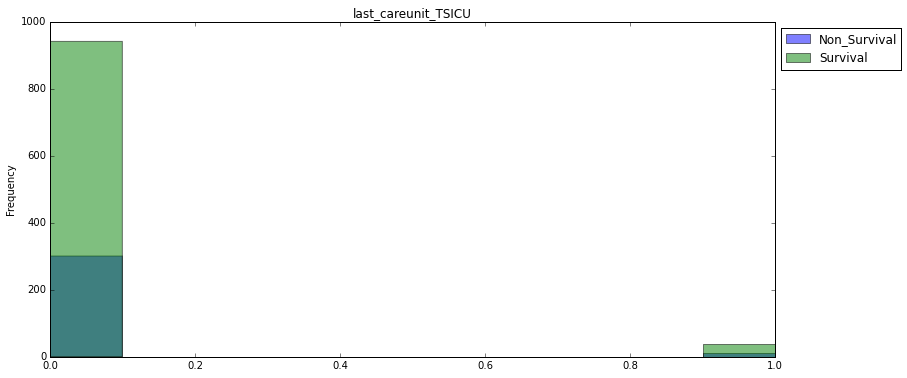

In [108]:
for item in cols:
    
    # plot
    plt.subplots(figsize=(13,6))
    ptnt_demog2[item][ptnt_demog2.hospital_expire_flag==1].plot.hist(
        alpha=0.5,label= 'Non_Survival')
    ptnt_demog2[item][ptnt_demog2.hospital_expire_flag==0].plot.hist(
        alpha=0.5,label= 'Survival')
    
    # fake plots for KS test, median, etc
    '''
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    '''
    # add title, labels etc.
    plt.title(item)
    #plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    #if l in lab_ranges:
    #    plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
    #    plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

In [114]:
display(ptnt_demog2.shape)
display(ptnt_demog2.dropna().shape)

(1290, 55)

(1197, 55)

In [115]:
ptnt_demog2.dropna(inplace = True)
ptnt_demog2.shape

(1197, 55)

In [117]:
ptnt_demog2_scaled = ptnt_demog2.copy()
for feature_name in ptnt_demog2_scaled.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    ptnt_demog2_scaled[feature_name] = preprocessing.scale(ptnt_demog2_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(ptnt_demog2_scaled.head())

,hospital_expire_flag,age,adm_stay_days,icu_stay_hours,gender_F,gender_M,diagnosis_SEPSIS,insurance_Government,insurance_Medicaid,insurance_Medicare,...,first_careunit_MICU,first_careunit_NICU,first_careunit_SICU,first_careunit_TSICU,last_careunit_CCU,last_careunit_CSRU,last_careunit_MICU,last_careunit_NICU,last_careunit_SICU,last_careunit_TSICU
0,1,1.460680,0.032291,0.864047,-0.858662,0.858662,0.0,-0.130355,-0.310087,0.708436,...,0.515100,-0.028916,-0.319703,-0.20439,-0.229718,-0.112651,0.520289,-0.028916,-0.352056,-0.202162
1,0,0.612147,-0.783776,-0.573248,-0.858662,0.858662,0.0,-0.130355,-0.310087,0.708436,...,-1.941372,-0.028916,-0.319703,-0.20439,4.353160,-0.112651,-1.922009,-0.028916,-0.352056,-0.202162
2,0,1.003778,-0.635401,-0.270660,-0.858662,0.858662,0.0,-0.130355,-0.310087,0.708436,...,0.515100,-0.028916,-0.319703,-0.20439,-0.229718,-0.112651,0.520289,-0.028916,-0.352056,-0.202162
4,0,-0.889102,-0.857964,-0.564843,-0.858662,0.858662,0.0,-0.130355,-0.310087,-1.411559,...,-1.941372,-0.028916,3.127904,-0.20439,-0.229718,-0.112651,-1.922009,-0.028916,2.840455,-0.202162
5,0,-0.171113,1.293485,-0.501804,-0.858662,0.858662,0.0,-0.130355,-0.310087,0.708436,...,0.515100,-0.028916,-0.319703,-0.20439,-0.229718,-0.112651,0.520289,-0.028916,-0.352056,-0.202162


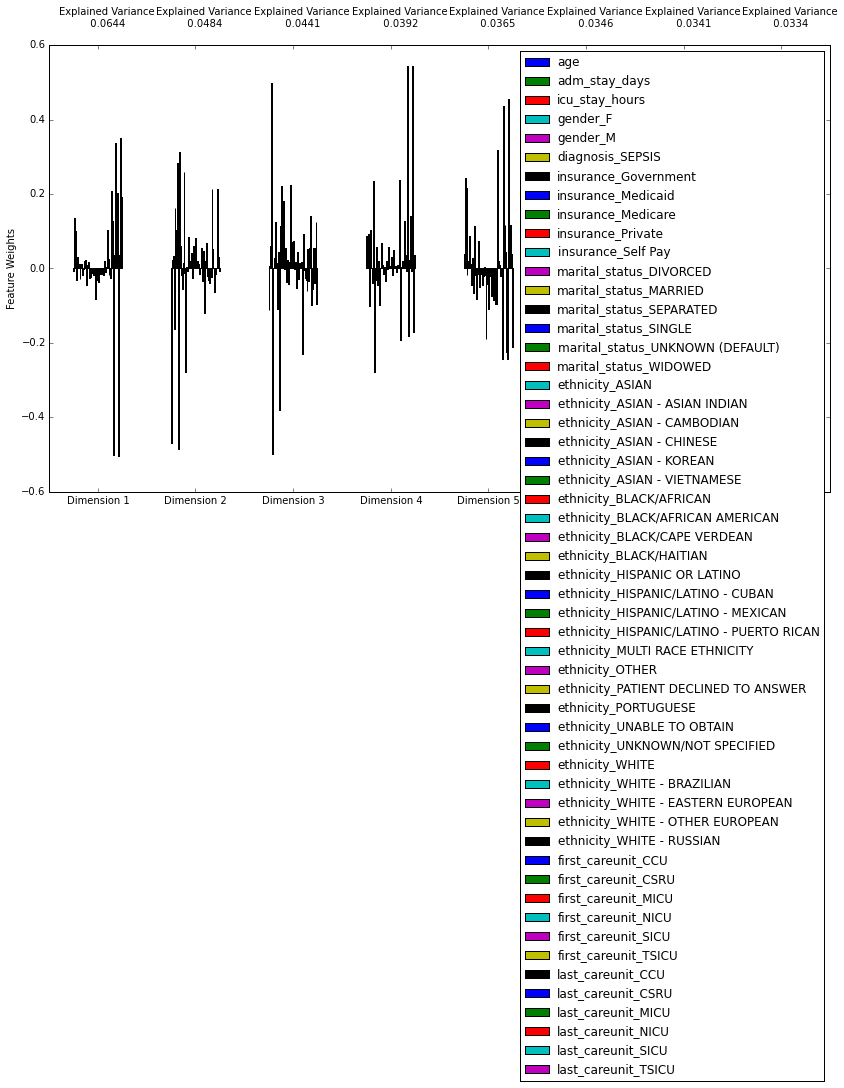

In [119]:
pca = PCA(n_components = 8).fit(ptnt_demog2_scaled[ptnt_demog2_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(ptnt_demog2_scaled[ptnt_demog2_scaled.columns[1:]], pca)



In [122]:
features = ptnt_demog2_scaled[ptnt_demog2_scaled.columns[1:]]
targets = ptnt_demog2_scaled[ptnt_demog2_scaled.columns[0]]
display(features.columns)
display(targets.name)

Index([u'age', u'adm_stay_days', u'icu_stay_hours', u'gender_F', u'gender_M',
       u'diagnosis_SEPSIS', u'insurance_Government', u'insurance_Medicaid',
       u'insurance_Medicare', u'insurance_Private', u'insurance_Self Pay',
       u'marital_status_DIVORCED', u'marital_status_MARRIED',
       u'marital_status_SEPARATED', u'marital_status_SINGLE',
       u'marital_status_UNKNOWN (DEFAULT)', u'marital_status_WIDOWED',
       u'ethnicity_ASIAN', u'ethnicity_ASIAN - ASIAN INDIAN',
       u'ethnicity_ASIAN - CAMBODIAN', u'ethnicity_ASIAN - CHINESE',
       u'ethnicity_ASIAN - KOREAN', u'ethnicity_ASIAN - VIETNAMESE',
       u'ethnicity_BLACK/AFRICAN', u'ethnicity_BLACK/AFRICAN AMERICAN',
       u'ethnicity_BLACK/CAPE VERDEAN', u'ethnicity_BLACK/HAITIAN',
       u'ethnicity_HISPANIC OR LATINO', u'ethnicity_HISPANIC/LATINO - CUBAN',
       u'ethnicity_HISPANIC/LATINO - MEXICAN',
       u'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
       u'ethnicity_MULTI RACE ETHNICITY', u'ethnicity_OTHER

'hospital_expire_flag'

In [129]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, 
                                                    test_size = 0.30, random_state = 42)

In [126]:
clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, features, targets, cv=5)
display(scores)  

array([ 0.76666667,  0.76666667,  0.76666667,  0.76569038,  0.7605042 ])

In [127]:
y_predsSVC = clf_SVC.predict(X_test)
metrics.confusion_matrix(y_test, y_predsSVC)



array([[283,   0],
       [ 76,   1]])

In [128]:
#X_train, X_test, y_train, y_test = train_test_split(reduced_data, targets,
#                                                   test_size = 0.30, 
#                                                  random_state = 42)

clf_MLP = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




0.78611111111111109

array([[283,   0],
       [ 77,   0]])

In [130]:
### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)




0.219444444444


array([[  6, 277],
       [  4,  73]])